## Initial imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, pickle
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from chython import smiles

# Model optimization

The optimization of model hyperparameters in DOPtools is based on Optuna library. It perform the search in the hyperparameter space that includes the descriptor space and the values of hyperparameters for the selected method. It works for both regression and classification models with SVM, Random Forest and XGBoost methods. Let's see how the optimization works on the example of photoswitches.

In [3]:
# First, calculation of descriptors. For now, only one descriptor space will be calculated.

photoswitches = pd.read_table("../examples/photoswitches.csv", sep=",", index_col=0)
data_lambda = photoswitches[pd.notnull(photoswitches['E isomer pi-pi* wavelength in nm'])]
lambda_mols = [smiles(s) for s in data_lambda.SMILES]
[m.canonicalize() for m in lambda_mols]
[m.clean2d() for m in lambda_mols]

from doptools import ChythonCircus

circus_fragmentor = ChythonCircus(0, 4) 

circus_fragmentor.fit(lambda_mols) 
circus_descriptors = circus_fragmentor.transform(lambda_mols) 


In [7]:
from doptools.optimizer import *

# This is necessary for Optuna parallelization to work on MacBook
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

optimization_study = launch_study({"circus":circus_descriptors},  # the descriptor space should be given as a dictionary {name:descriptor_table, ...}
                                  data_lambda[['E isomer pi-pi* wavelength in nm']], # the modeled property, has to be a DataFrame, not Series!
                                  "", # output directory, here the results are saved in the variable, so not needed
                                  "SVR", # the methods, Support Vector Regression
                                  500, # number of hyperparameter setups to try. This will take some time!
                                  10, # number of folds in K-fold CV
                                  5, # number of repeats of CV
                                  5, # number of CPUs to use in parallel
                                  120, # timeout, in sec, to kill a process if it is stuck
                                  (0, 0), # early stopiing, here we don't use it
                                  False) # write output into files, here we save in a variable, so not needed

The optimization doesn't go very long, so high performance is not expected in this illustrative case. 

*optimization_study* variable contains two things. First, a table of the results where each trial is shown with the hyperparameters that were chosen and the final score in cross-validation (in regression, it is $R^2$). The table can be sorted by the score to see the best result:

In [11]:
optimization_table = optimization_study[0]
optimization_table.sort_values(by="score", ascending=False)

,trial,score,desc,scaling,method,C,kernel,coef0
336,163,0.408167,circus,scaled,SVR,5.336336e-01,linear,-7.787811
327,172,0.408071,circus,scaled,SVR,4.556477e+01,poly,2.689173
23,476,0.406965,circus,scaled,SVR,6.019117e+02,rbf,4.057874
395,104,0.405716,circus,original,SVR,2.199162e-02,linear,-1.875857
396,103,0.405716,circus,original,SVR,2.199162e-02,linear,-1.875857
...,...,...,...,...,...,...,...,...
453,46,NaN,circus,original,SVR,2.491202e+07,linear,-1.435053
464,35,NaN,circus,original,SVR,8.833175e+07,linear,9.329989
479,20,NaN,circus,original,SVR,5.800260e+04,linear,-9.356982
481,18,NaN,circus,scaled,SVR,1.402863e+07,linear,8.264779


The second part is the dictionary with all prediction results, so that the regression plots etc can be built. To access the predictions of the best scoring model, you should use the trial number.

In [12]:
optimization_predictions = optimization_study[1]
optimization_predictions[optimization_table.sort_values(by="score", ascending=False).iloc[0]["trial"]]["predictions"]

,data_index,E isomer pi-pi* wavelength in nm.observed,E isomer pi-pi* wavelength in nm.predicted.repeat1,E isomer pi-pi* wavelength in nm.predicted.repeat2,E isomer pi-pi* wavelength in nm.predicted.repeat3,E isomer pi-pi* wavelength in nm.predicted.repeat4,E isomer pi-pi* wavelength in nm.predicted.repeat5
0,1,310.0,362.206108,362.109889,360.199417,360.594825,360.375915
1,2,310.0,354.650928,355.984233,354.546314,354.395568,354.465282
2,3,320.0,337.052947,336.579033,336.694784,337.400654,337.426303
3,4,325.0,341.825762,342.250903,342.626776,342.215216,341.925445
4,5,328.0,339.454797,337.641494,339.674751,345.223712,343.042418
...,...,...,...,...,...,...,...
387,388,401.0,418.506004,420.613820,420.569981,421.035552,422.735173
388,389,413.0,413.841124,416.884805,410.798107,414.961746,415.107485
389,390,414.0,393.675220,400.231295,401.575491,401.222351,396.669702
390,391,428.0,383.583223,379.587893,373.380374,378.954238,380.523979


# Results visualization

For the visualization of the optimization results we will use the pre-calculated model on photoswitches (forlder Model_Epipi_regr). The best results were given by the trial 456 as it can be seen in the *trials.best* file. The *predictions* file in the corresponding folder contains the predictions of 10-fold cross-validation using these hyperparameters, for each repeat of the CV and the consensus. The function *make_regression_plot* can use that file to create a regression results plot (observed vs prediction) with the statistics shown.

In [2]:
best_regr = pd.read_table("Model_Epipi_regr/trials.best", sep=" ").iloc[0]
best_regr

trial              456
score         0.912902
desc        circus-0-5
scaling       original
method             SVR
C          2466.956797
kernel             rbf
coef0        -0.503667
Name: 0, dtype: object

In [3]:
regr_results = pd.read_table("Model_Epipi_regr/trial."+str(best_regr["trial"])+"/predictions", sep=" ")
regr_results

,data_index,Epipi.observed,Epipi.predicted.repeat1,Epipi.predicted.repeat2,Epipi.predicted.repeat3,Epipi.predicted.repeat4,Epipi.predicted.repeat5
0,1,310.0,324.716,326.277,327.871,330.886,331.132
1,2,310.0,327.969,321.603,326.812,326.453,327.504
2,3,320.0,327.032,330.890,335.650,335.851,330.145
3,4,325.0,321.908,321.502,337.383,337.853,322.130
4,5,328.0,320.545,322.714,324.706,324.408,323.155
...,...,...,...,...,...,...,...
387,388,456.0,458.350,454.368,453.842,455.086,454.796
388,389,437.0,457.954,458.965,454.420,455.871,458.255
389,390,545.0,538.337,539.772,540.178,539.381,540.967
390,391,535.0,421.456,418.606,418.568,418.569,415.465


In [78]:
regr_file_name = "lambda/Model_Epipi_regr/trial."+str(best_regr["trial"])+"/predictions"

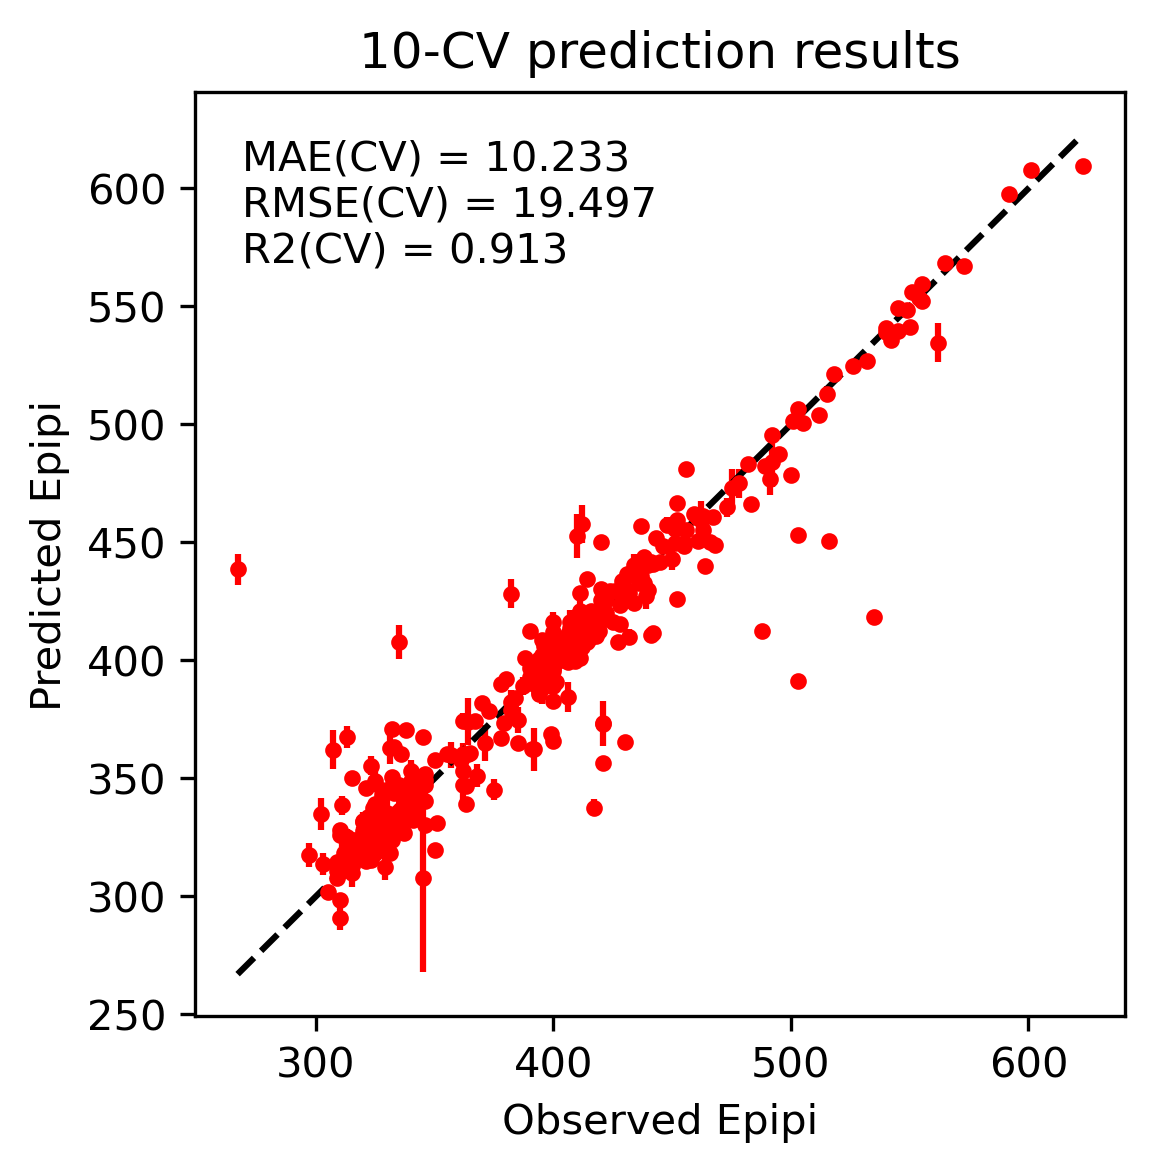

In [79]:
from doptools.cli.plotter import make_regression_plot

fig1, ax1 = make_regression_plot(regr_file_name, 
                                 errorbar=True, 
                                 stats=True, 
                                 title="10-CV prediction results")


Similarly, the classification results plots are built. In this tutorial, we show the example of blood-brain barrier penetration dataset (*bbb* folder). 

In [6]:
best_class = pd.read_table("bbb/Model_avalon/trials.best", sep=" ").iloc[0]
best_class

trial                   215
score              0.873575
desc            avalon_1024
scaling              scaled
method                  RFC
max_depth                10
max_features            NaN
max_samples             0.7
n_estimators             50
Name: 0, dtype: object

Classification results matrix contains the observed and predicted labels for each repeat of the CV, as in the regression models. However, here you also have the predicted probability of each class (*predicted_prob.class_n*), as it is needed to correctly evaluate and build the ROC curve.

In [10]:
class_results = pd.read_table("bbb/Model_avalon/trial."+str(best_class["trial"])+"/predictions", sep=" ")
class_results

,data_index,Active.observed,Active.predicted.class.repeat1,Active.predicted_prob.class_0.repeat1,Active.predicted_prob.class_1.repeat1,Active.predicted.class.repeat2,Active.predicted_prob.class_0.repeat2,Active.predicted_prob.class_1.repeat2,Active.predicted.class.repeat3,Active.predicted_prob.class_0.repeat3,Active.predicted_prob.class_1.repeat3,Active.predicted.class.repeat4,Active.predicted_prob.class_0.repeat4,Active.predicted_prob.class_1.repeat4,Active.predicted.class.repeat5,Active.predicted_prob.class_0.repeat5,Active.predicted_prob.class_1.repeat5
0,1,1,1,0.021,0.979,1,0.013,0.987,1,0.016,0.984,1,0.011,0.989,1,0.011,0.989
1,2,1,1,0.051,0.949,1,0.213,0.787,1,0.284,0.716,1,0.083,0.917,1,0.064,0.936
2,3,1,1,0.104,0.896,1,0.030,0.970,1,0.010,0.990,1,0.062,0.938,1,0.041,0.959
3,4,1,1,0.016,0.984,1,0.020,0.980,1,0.031,0.969,1,0.029,0.971,1,0.010,0.990
4,5,1,1,0.082,0.918,1,0.011,0.989,1,0.033,0.967,1,0.117,0.883,1,0.043,0.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1396,1,1,0.042,0.958,1,0.079,0.921,1,0.011,0.989,1,0.035,0.965,1,0.031,0.969
1396,1397,1,1,0.130,0.870,1,0.125,0.875,1,0.091,0.909,1,0.059,0.941,1,0.065,0.935
1397,1398,1,0,1.000,0.000,0,1.000,0.000,0,1.000,0.000,0,1.000,0.000,0,1.000,0.000
1398,1399,1,1,0.078,0.922,1,0.113,0.887,1,0.129,0.871,1,0.248,0.752,1,0.109,0.891


In [80]:
class_file_name = "bbb/Model_avalon/trial."+str(best_class["trial"])+"/predictions"

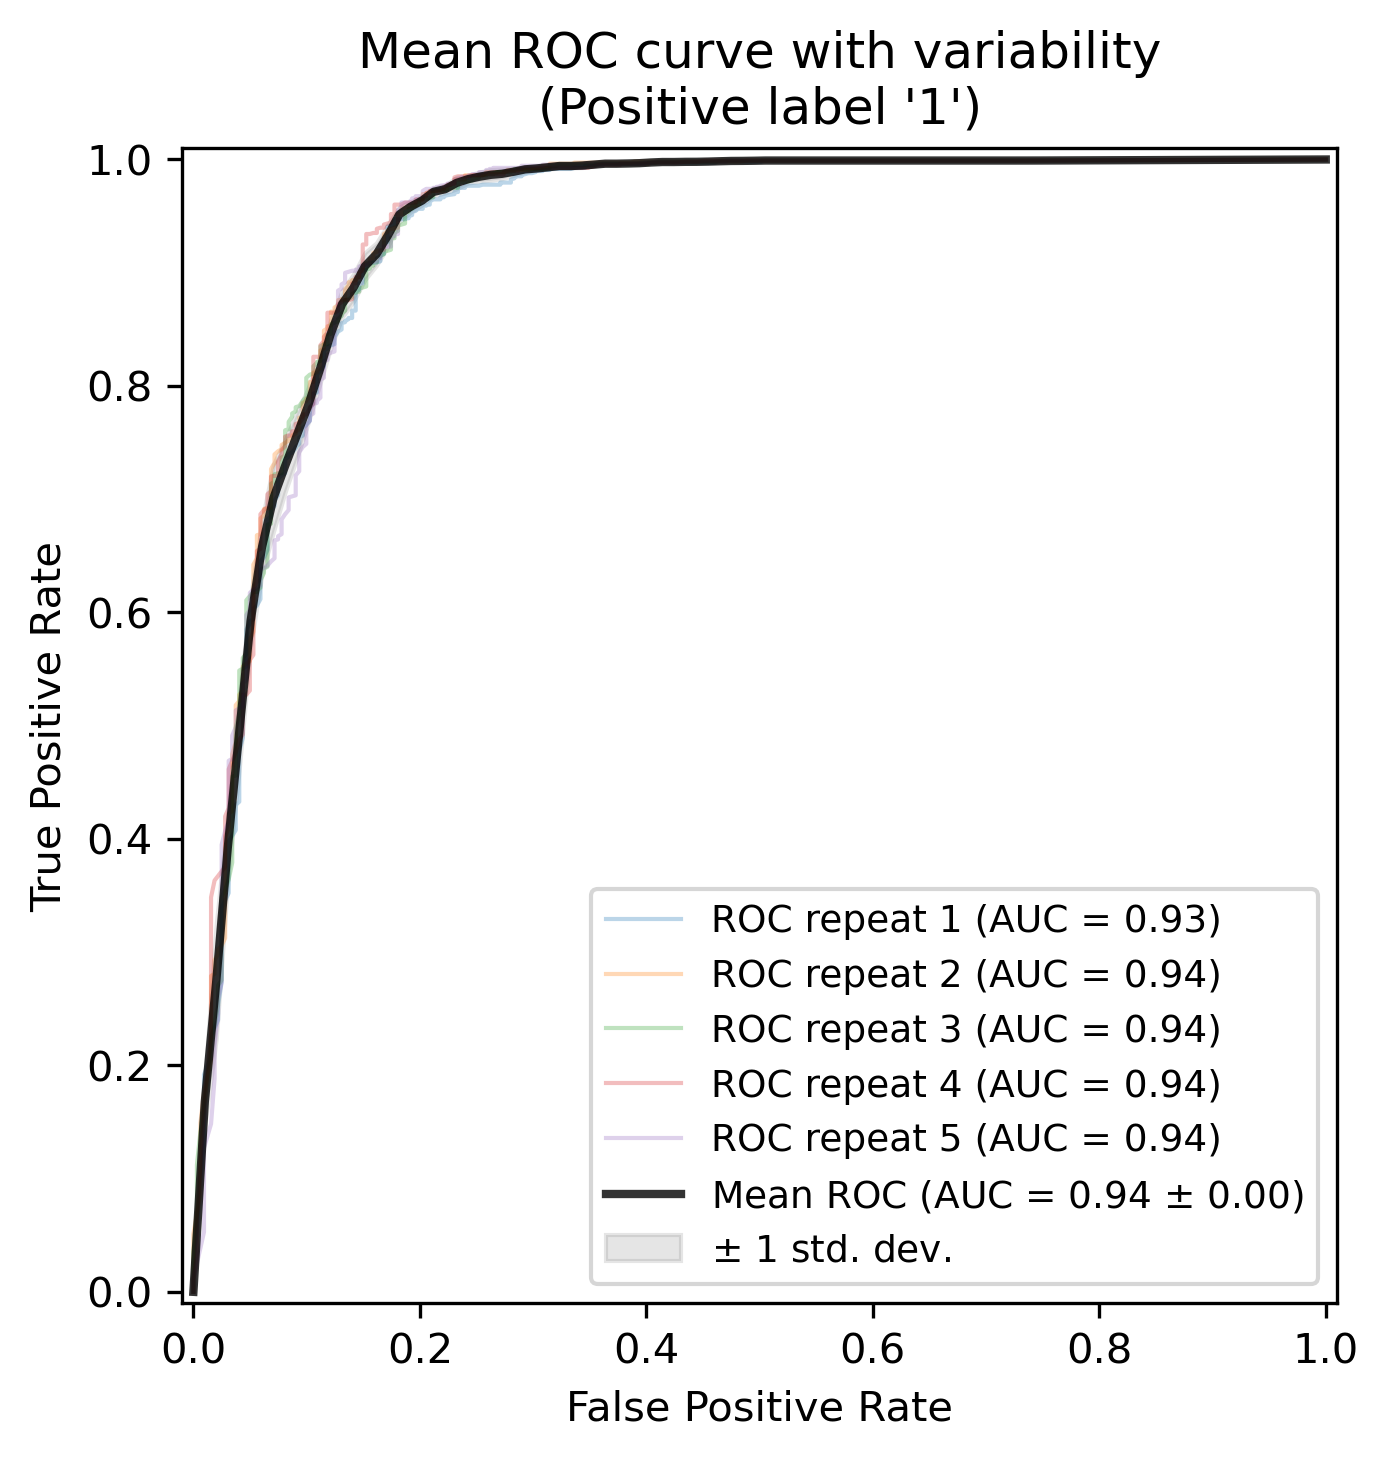

In [16]:
from doptools.cli.plotter import make_classification_plot

fig2, ax2 = make_classification_plot(class_file_name, 
                                     class_number=1)